In [ ]:
# import libraries/packages
# Neural Network:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
# for Transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from copy import copy
import torchio as tio
from skimage.transform import resize
from skimage.util import montage
# for import directory
import os
# for reading .nii.gz files
import nibabel as nib
import scipy.ndimage as ndi
import re
# cv2 and numpy
import cv2
import numpy as np
# for visual
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
# Define paths
train_path = 'Datasets/MSSEG-2016/Training'
test_path = 'Datasets/MSSEG-2016/Testing'

In [ ]:
# Extract paths
FLAIR_path = []
mask_path = []
for subdir, dirs, files in os.walk(test_path):
    for file in files:
      if re.fullmatch('FLAIR_preprocessed.nii.gz', file):
        filename = os.path.join(subdir, file)
        FLAIR_path.append(filename)
      if re.fullmatch('Consensus.nii.gz', file):
        filename = os.path.join(subdir, file)
        mask_path.append(filename)

In [ ]:
def crop_sample(volume, mask):
    volume[volume < np.max(volume) * 0.01] = 0
    nz = np.nonzero(volume)
    z_min = np.min(nz[2])
    z_max = np.max(nz[2]) + 1
    y_min = np.min(nz[1])
    y_max = np.max(nz[1]) + 1
    x_min = np.min(nz[0])
    x_max = np.max(nz[0]) + 1
    return (
        volume[x_min:x_max, y_min:y_max, z_min:z_max],
        mask[x_min:x_max, y_min:y_max, z_min:z_max],
    )

In [ ]:
# sanity check that associated FLAIR and masks are loaded
print(len(FLAIR_path))
print(len(mask_path))

38
38


In [ ]:
# for data loading
def read_nifti(path):
  # many slices have a blank mask (need to remove these)
  scan = nib.load(path).get_fdata()
  return scan

# resize the scan using zoom function
def resize_scan(scan):
    
  # convert to float to work with nn (original uint16 not supported)
  scan = np.float32(scan)

  return scan

# data loading process
def process_scan(path):
  scan = read_nifti(path)
  scan = resize_scan(scan)
  return scan

In [ ]:
# Load FLAIR and mask scans
FLAIR_scans = [process_scan(path) for path in FLAIR_path]
mask_scans = [process_scan(path) for path in mask_path]

In [ ]:
# sanity check for ensuring uniform sizes of scans
for i in range(len(FLAIR_scans)):
  print(FLAIR_scans[i].shape)

(261, 336, 336)
(240, 336, 336)
(261, 336, 336)
(245, 336, 336)
(261, 336, 336)
(261, 336, 336)
(261, 336, 336)
(261, 336, 336)
(261, 336, 336)
(261, 336, 336)
(128, 228, 256)
(128, 244, 256)
(128, 224, 256)
(128, 224, 256)
(128, 224, 256)
(128, 224, 256)
(128, 224, 256)
(128, 224, 256)
(128, 224, 256)
(128, 224, 256)
(224, 512, 512)
(224, 512, 512)
(224, 512, 512)
(224, 512, 512)
(224, 512, 512)
(224, 512, 512)
(224, 512, 512)
(224, 512, 512)
(144, 512, 512)
(144, 512, 512)
(144, 512, 512)
(144, 512, 512)
(144, 512, 512)
(144, 512, 512)
(144, 512, 512)
(144, 512, 512)
(144, 512, 512)
(144, 512, 512)


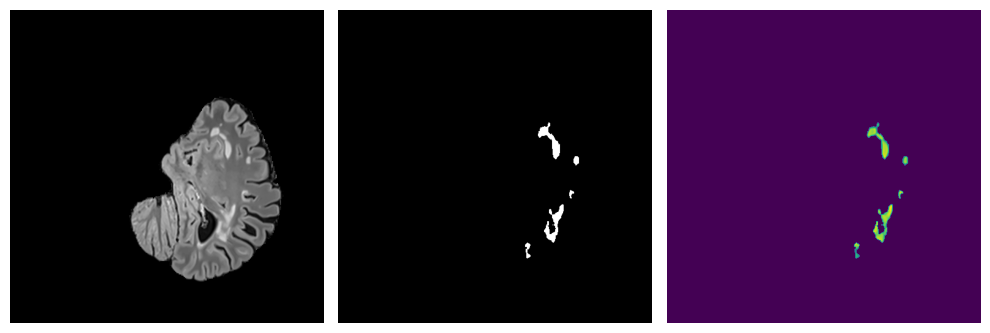

In [ ]:
fig_rows = 1
fig_cols = 3

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])

sl = 100
n = 30

axs.flat[0].imshow(FLAIR_scans[n][sl, :, :], cmap='gray')
axs.flat[0].axis('off')
axs.flat[1].imshow(mask_scans[n][sl, :, :], cmap='gray')
axs.flat[1].axis('off')
axs.flat[2].imshow(FLAIR_scans[n][sl, :, :]*mask_scans[n][sl, :, :])
axs.flat[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Custom Class for Loading the Dataset
# Dataset Loading Class
class LoadDataset(Dataset):
    def __init__(self, imageScan , maskScan, transform=False):
        self.imageScan = imageScan
        self.maskScan = maskScan
        self.transform = transform

    # returns number of scans in dataset/directory
    def __len__(self):
        return len(self.imageScan)

    # return the image and mask in dataset
    def __getitem__(self, idx):
        imageScan = self.imageScan
        maskScan = self.maskScan

        # extract entire scan
        image = imageScan[idx]
        mask = maskScan[idx]

        # remove black layers
        image, mask = crop_sample(image, mask)
        
        # Apply basic transforms
        if self.transform is not None:
            #  Apply same tranform to image and mask
            flip_pr = 0.5
            if np.random.rand() > flip_pr:
                image = np.fliplr(image).copy()
                mask = np.fliplr(mask).copy()

            #angle = np.random.uniform(low=-45, high=45)
            #image = ndi.rotate(image, angle)
            #mask = ndi.rotate(mask, angle)
            
        # resize
        image = resize(image, (128,128,128), preserve_range=True)
        mask = resize(mask, (128,128,128), preserve_range=True)
            
        # binarize mask
        mask[mask >= 0.5] = 1.0  
        mask[mask < 0.5] = 0.0
        
        # normalize scan
        image = (image-np.min(image))/(np.max(image)-np.min(image))

        return image, mask

In [ ]:
# Create U-Net Neural Network as seen in Figure above
class Unet3D(nn.Module):
    def __init__(self):
        super().__init__()
        #encoding path
        self.layer1 = self.encLayer(1, 64)
        self.layer2 = self.encLayer(64, 128)
        self.layer3 = self.encLayer(128, 256)
        self.layer4 = self.encLayer(256, 512)
        self.pool = nn.MaxPool3d((2,2,2))
        #decoding path (concatenate with outputs from encoding layers)
        self.layer5 = self.decLayer(256+512, 256)
        self.layer6 = self.decLayer(256+128, 128)
        self.layer7 = self.decLayer(64+128, 64)
        self.up = nn.Upsample(scale_factor=2, mode='trilinear')
        #output layer
        self.out = self.outLayer(64,1)

    # Encoding layer consists of (2): Conv3d + BatchNorm + Relu
    # filter size = 3, padding = 1, stride = 1
    # no biases due to batching
    def encLayer(self, inCh, outCh):
        Encode = nn.Sequential(
            nn.Conv3d(inCh, outCh, 3, 1, 1, bias=False),
            nn.BatchNorm3d(outCh),
            nn.ReLU(inplace=True),
            nn.Conv3d(outCh, outCh, 3, 1, 1, bias=False),
            nn.BatchNorm3d(outCh),
            nn.ReLU(inplace=True))
        return Encode

    # Decoding Layer consists of (2): Conv3D + BachNorm + ReLu
    def decLayer(self, inCh, outCh):
        Decode = nn.Sequential(
            nn.Conv3d(inCh, outCh, 3, 1, 1, bias=False),
            nn.BatchNorm3d(outCh),
            nn.ReLU(inplace=True),
            nn.Conv3d(outCh, outCh, 3, 1, 1, bias=False),
            nn.BatchNorm3d(outCh),
            nn.ReLU(inplace=True))
        return Decode
    
    # Output Layer consists of: Conv3D + Sigmoid 
    def outLayer(self, inCh, outCh):
        Output = nn.Sequential(
            nn.Conv3d(inCh, outCh, 3, 1, 1),
            nn.Sigmoid())
        return Output

    # Create forward path for U-net
    def forward(self, x):
        # encoding path
        x1 = self.layer1(x)
        x2 = self.layer2(self.pool(x1))
        x3 = self.layer3(self.pool(x2))
        x4 = self.layer4(self.pool(x3))
        # decoding path (concatenate outputs from encoding path)
        x5 = self.layer5(torch.cat([self.up(x4), x3], 1))
        x6 = self.layer6(torch.cat([self.up(x5), x2], 1))
        x7 = self.layer7(torch.cat([self.up(x6), x1], 1))
        # output
        output = self.out(x7)
        return output

In [ ]:
# Create class for Custom Loss Function
# SoftDICE Loss Function Class
class SoftDice(nn.Module):
    def __init__(self):
        super().__init__()
    
    # forward execution to calcuate Loss
    def forward(self, y_true, y_hat):
        # flatten the inputs into vectors of (1 by batch*#ch*height*width)
        y_true = y_true.view(1, -1)
        y_hat = y_hat.view(1, -1)

        # calculate intersection and union
        intersection = (y_true*y_hat).sum()
        union = y_true.sum() + y_hat.sum()
        
        # calculate Soft DICE score
        e = 1.0
        dice = (2.*intersection + e)/(union + e)
        
        # calculate Soft DICE loss
        sdloss = 1. - dice
        
        return sdloss

In [ ]:
# Use GPU (cuda) for Training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# Pin memory for GPU
PIN_MEMORY = True if DEVICE == "cuda" else False

cuda


In [ ]:
# Some hyperparameters
batch_sz = 2  # batch size
n_ep = 100     # number of epochs
LR = 1e-4    # learning rate

In [ ]:
# Load Dataset
dataset = LoadDataset(FLAIR_scans, mask_scans, transform=False)

# split randomly into 80-10-10 train-val-test
generator = torch.Generator().manual_seed(42)
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

# apply data augmentation to train_set
train_set.dataset = copy(dataset)
train_set.dataset.transform = True

# create dataloaders
trainLoader = DataLoader(train_set, batch_size=batch_sz, shuffle=True, pin_memory=PIN_MEMORY)
valLoader = DataLoader(val_set, batch_size=batch_sz, shuffle=False,  pin_memory=PIN_MEMORY)
testLoader = DataLoader(test_set, batch_size=batch_sz, shuffle=False,  pin_memory=PIN_MEMORY)

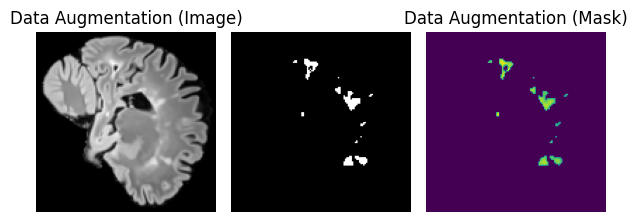

In [ ]:
# show example data augmentation
images, masks = next(iter(trainLoader))
images = images[0].numpy()
masks = masks[0].numpy()

fig_rows = 1
fig_cols = 3

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[6, 6])

axs.flat[0].set_title('Data Augmentation (Image)')
axs.flat[0].imshow(images[45,:,:], cmap='gray')
axs.flat[0].axis('off')
axs.flat[1].imshow(masks[45,:,:], cmap='gray')
axs.flat[1].axis('off')
axs.flat[2].set_title('Data Augmentation (Mask)')
axs.flat[2].imshow(images[45,:,:]*masks[45,:,:])
axs.flat[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Build Model, optimizer, scheduler, specify Loss Func, etc.
model = Unet3D().to(DEVICE)
lossFunc = SoftDice()
optimizer = Adam(model.parameters(), lr=LR)

# schedule to decrease the initial LR to 0.1LR in the number of epochs
scheduler = lr_scheduler.LinearLR(optimizer, 1.0, 0.1, n_ep)

# for storing training history
H = {"train_loss": [], "val_loss": [], "val_dice": []}

In [ ]:
# Double check U-Net Model (show summary)
from torchsummary import summary
summary = summary(model, (1,128, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 64, 128, 128, 128]           1,728
       BatchNorm3d-2    [-1, 64, 128, 128, 128]             128
              ReLU-3    [-1, 64, 128, 128, 128]               0
            Conv3d-4    [-1, 64, 128, 128, 128]         110,592
       BatchNorm3d-5    [-1, 64, 128, 128, 128]             128
              ReLU-6    [-1, 64, 128, 128, 128]               0
         MaxPool3d-7       [-1, 64, 64, 64, 64]               0
            Conv3d-8      [-1, 128, 64, 64, 64]         221,184
       BatchNorm3d-9      [-1, 128, 64, 64, 64]             256
             ReLU-10      [-1, 128, 64, 64, 64]               0
           Conv3d-11      [-1, 128, 64, 64, 64]         442,368
      BatchNorm3d-12      [-1, 128, 64, 64, 64]             256
             ReLU-13      [-1, 128, 64, 64, 64]               0
        MaxPool3d-14      [-1, 128, 32,

In [ ]:
# Training and Validation
# loop over epochs
bestDice = 0.0
for e in tqdm(range(n_ep)):
    # train
    model.train()
    # initialize metrics
    trainLoss = 0.0
    valLoss = 0.0
    valDice = 0.0
    train_ct = 0.0
    val_ct = 0.0
    # loop through training set in batches
    for idx, data in enumerate(trainLoader):
        x = data[0].unsqueeze(1).to(DEVICE)
        y = data[1].unsqueeze(1).to(DEVICE)

        y_hat = model(x)
        
        loss = lossFunc(y, y_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
        trainLoss += loss
        train_ct += 1.0

    with torch.no_grad():
        # validate
        model.eval()
        # loop through validation set in batches
        for data in valLoader:
            x = data[0].unsqueeze(1).to(DEVICE)
            y = data[1].unsqueeze(1).to(DEVICE)

            y_hat = model(x)

            loss = lossFunc(y, y_hat)

            valLoss += loss
            val_ct += 1.0

    # compute average metrics over datasets
    avgTrainLoss = trainLoss/train_ct
    avgValLoss = valLoss/val_ct
    avgValDice = 1-avgValLoss
    
    if bestDice < avgValDice:
        bestDice = avgValDice
        torch.save(model, 'Models/Unet_3D')

    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_dice"].append(avgValDice.cpu().detach().numpy())

    # print metrics
    print("")
    print("Train loss: {:.4f}, Validation loss: {:.4f}, Valdiation DICE Curve: {:.4f}".format(avgTrainLoss, avgValLoss, avgValDice))

  1%|          | 1/100 [01:02<1:42:21, 62.03s/it]


Train loss: 0.9819, Validation loss: 0.9896, Valdiation DICE Curve: 0.0104


  2%|▏         | 2/100 [02:02<1:39:49, 61.12s/it]


Train loss: 0.9671, Validation loss: 0.9778, Valdiation DICE Curve: 0.0222


  3%|▎         | 3/100 [03:04<1:39:14, 61.39s/it]


Train loss: 0.9426, Validation loss: 0.9429, Valdiation DICE Curve: 0.0571


  4%|▍         | 4/100 [04:05<1:38:05, 61.31s/it]


Train loss: 0.8658, Validation loss: 0.9364, Valdiation DICE Curve: 0.0636


  5%|▌         | 5/100 [05:07<1:37:14, 61.42s/it]


Train loss: 0.7456, Validation loss: 0.7728, Valdiation DICE Curve: 0.2272


  6%|▌         | 6/100 [06:08<1:36:04, 61.33s/it]


Train loss: 0.6286, Validation loss: 0.5261, Valdiation DICE Curve: 0.4739


  7%|▋         | 7/100 [07:07<1:34:09, 60.75s/it]


Train loss: 0.6384, Validation loss: 0.5722, Valdiation DICE Curve: 0.4278


  8%|▊         | 8/100 [08:08<1:33:01, 60.67s/it]


Train loss: 0.5930, Validation loss: 0.7281, Valdiation DICE Curve: 0.2719


  9%|▉         | 9/100 [09:09<1:32:13, 60.81s/it]


Train loss: 0.5830, Validation loss: 0.8360, Valdiation DICE Curve: 0.1640


 10%|█         | 10/100 [10:11<1:31:55, 61.28s/it]


Train loss: 0.6420, Validation loss: 0.8834, Valdiation DICE Curve: 0.1166


 11%|█         | 11/100 [11:14<1:31:29, 61.68s/it]


Train loss: 0.5912, Validation loss: 0.4480, Valdiation DICE Curve: 0.5520


 12%|█▏        | 12/100 [12:13<1:29:26, 60.98s/it]


Train loss: 0.5159, Validation loss: 0.4689, Valdiation DICE Curve: 0.5311


 13%|█▎        | 13/100 [13:15<1:28:47, 61.24s/it]


Train loss: 0.5159, Validation loss: 0.3241, Valdiation DICE Curve: 0.6759


 14%|█▍        | 14/100 [14:16<1:27:33, 61.09s/it]


Train loss: 0.4339, Validation loss: 0.3670, Valdiation DICE Curve: 0.6330


 15%|█▌        | 15/100 [15:14<1:25:29, 60.35s/it]


Train loss: 0.4654, Validation loss: 0.3932, Valdiation DICE Curve: 0.6068


 16%|█▌        | 16/100 [16:13<1:23:55, 59.95s/it]


Train loss: 0.4990, Validation loss: 0.2963, Valdiation DICE Curve: 0.7037


 17%|█▋        | 17/100 [17:16<1:23:55, 60.67s/it]


Train loss: 0.4081, Validation loss: 0.4030, Valdiation DICE Curve: 0.5970


 18%|█▊        | 18/100 [18:15<1:22:29, 60.36s/it]


Train loss: 0.3877, Validation loss: 0.3458, Valdiation DICE Curve: 0.6542


 19%|█▉        | 19/100 [19:15<1:21:01, 60.02s/it]


Train loss: 0.4215, Validation loss: 0.4468, Valdiation DICE Curve: 0.5532


 20%|██        | 20/100 [20:14<1:19:44, 59.80s/it]


Train loss: 0.4344, Validation loss: 0.3477, Valdiation DICE Curve: 0.6523


 21%|██        | 21/100 [21:15<1:19:16, 60.21s/it]


Train loss: 0.3786, Validation loss: 0.2754, Valdiation DICE Curve: 0.7246


 22%|██▏       | 22/100 [22:18<1:19:10, 60.90s/it]


Train loss: 0.3761, Validation loss: 0.2799, Valdiation DICE Curve: 0.7201


 23%|██▎       | 23/100 [23:18<1:17:59, 60.78s/it]


Train loss: 0.4006, Validation loss: 0.3851, Valdiation DICE Curve: 0.6149


 24%|██▍       | 24/100 [24:18<1:16:35, 60.47s/it]


Train loss: 0.4078, Validation loss: 0.3854, Valdiation DICE Curve: 0.6146


 25%|██▌       | 25/100 [25:19<1:15:44, 60.60s/it]


Train loss: 0.3706, Validation loss: 0.3373, Valdiation DICE Curve: 0.6627


 26%|██▌       | 26/100 [26:22<1:15:43, 61.40s/it]


Train loss: 0.3649, Validation loss: 0.2483, Valdiation DICE Curve: 0.7517


 27%|██▋       | 27/100 [27:23<1:14:26, 61.18s/it]


Train loss: 0.3377, Validation loss: 0.4752, Valdiation DICE Curve: 0.5248


 28%|██▊       | 28/100 [28:23<1:13:00, 60.85s/it]


Train loss: 0.3765, Validation loss: 0.2817, Valdiation DICE Curve: 0.7183


 29%|██▉       | 29/100 [29:23<1:11:50, 60.72s/it]


Train loss: 0.3640, Validation loss: 0.3058, Valdiation DICE Curve: 0.6942


 30%|███       | 30/100 [30:23<1:10:27, 60.39s/it]


Train loss: 0.3389, Validation loss: 0.4013, Valdiation DICE Curve: 0.5987


 31%|███       | 31/100 [31:23<1:09:32, 60.46s/it]


Train loss: 0.3773, Validation loss: 0.2852, Valdiation DICE Curve: 0.7148


 32%|███▏      | 32/100 [32:24<1:08:28, 60.41s/it]


Train loss: 0.3593, Validation loss: 0.3827, Valdiation DICE Curve: 0.6173


 33%|███▎      | 33/100 [33:25<1:07:53, 60.80s/it]


Train loss: 0.3460, Validation loss: 0.5476, Valdiation DICE Curve: 0.4524


 34%|███▍      | 34/100 [34:27<1:07:02, 60.94s/it]


Train loss: 0.3777, Validation loss: 0.2864, Valdiation DICE Curve: 0.7136


 35%|███▌      | 35/100 [35:26<1:05:23, 60.36s/it]


Train loss: 0.3220, Validation loss: 0.2918, Valdiation DICE Curve: 0.7082


 36%|███▌      | 36/100 [36:26<1:04:21, 60.34s/it]


Train loss: 0.3503, Validation loss: 0.2972, Valdiation DICE Curve: 0.7028


 37%|███▋      | 37/100 [37:25<1:02:56, 59.94s/it]


Train loss: 0.2956, Validation loss: 0.2695, Valdiation DICE Curve: 0.7305


 38%|███▊      | 38/100 [38:26<1:02:14, 60.23s/it]


Train loss: 0.3163, Validation loss: 0.2534, Valdiation DICE Curve: 0.7466


 39%|███▉      | 39/100 [39:25<1:00:52, 59.88s/it]


Train loss: 0.3067, Validation loss: 0.2470, Valdiation DICE Curve: 0.7530


 40%|████      | 40/100 [40:24<59:37, 59.62s/it]  


Train loss: 0.3115, Validation loss: 0.2532, Valdiation DICE Curve: 0.7468


 41%|████      | 41/100 [41:24<58:46, 59.78s/it]


Train loss: 0.3851, Validation loss: 0.3008, Valdiation DICE Curve: 0.6992


 42%|████▏     | 42/100 [42:25<58:01, 60.03s/it]


Train loss: 0.3623, Validation loss: 0.4452, Valdiation DICE Curve: 0.5548


 43%|████▎     | 43/100 [43:26<57:17, 60.30s/it]


Train loss: 0.3670, Validation loss: 0.2288, Valdiation DICE Curve: 0.7712


 44%|████▍     | 44/100 [44:27<56:38, 60.69s/it]


Train loss: 0.3353, Validation loss: 0.2907, Valdiation DICE Curve: 0.7093


 45%|████▌     | 45/100 [45:27<55:24, 60.45s/it]


Train loss: 0.2973, Validation loss: 0.2787, Valdiation DICE Curve: 0.7213


 46%|████▌     | 46/100 [46:27<54:08, 60.16s/it]


Train loss: 0.2660, Validation loss: 0.2521, Valdiation DICE Curve: 0.7479


 47%|████▋     | 47/100 [47:25<52:32, 59.49s/it]


Train loss: 0.3197, Validation loss: 0.2510, Valdiation DICE Curve: 0.7490


 48%|████▊     | 48/100 [48:26<51:57, 59.95s/it]


Train loss: 0.3049, Validation loss: 0.2602, Valdiation DICE Curve: 0.7398


 49%|████▉     | 49/100 [49:25<50:46, 59.74s/it]


Train loss: 0.3228, Validation loss: 0.2774, Valdiation DICE Curve: 0.7226


 50%|█████     | 50/100 [50:24<49:40, 59.61s/it]


Train loss: 0.2893, Validation loss: 0.3559, Valdiation DICE Curve: 0.6441


 51%|█████     | 51/100 [51:26<49:08, 60.17s/it]


Train loss: 0.2552, Validation loss: 0.2346, Valdiation DICE Curve: 0.7654


 52%|█████▏    | 52/100 [52:26<48:13, 60.28s/it]


Train loss: 0.2733, Validation loss: 0.2727, Valdiation DICE Curve: 0.7273


 53%|█████▎    | 53/100 [53:26<47:10, 60.23s/it]


Train loss: 0.2451, Validation loss: 0.2524, Valdiation DICE Curve: 0.7476


 54%|█████▍    | 54/100 [54:26<46:02, 60.05s/it]


Train loss: 0.2463, Validation loss: 0.2382, Valdiation DICE Curve: 0.7618


 55%|█████▌    | 55/100 [55:28<45:29, 60.66s/it]


Train loss: 0.2673, Validation loss: 0.3265, Valdiation DICE Curve: 0.6735


 56%|█████▌    | 56/100 [56:28<44:23, 60.54s/it]


Train loss: 0.2415, Validation loss: 0.3099, Valdiation DICE Curve: 0.6901


 57%|█████▋    | 57/100 [57:29<43:26, 60.61s/it]


Train loss: 0.2891, Validation loss: 0.2139, Valdiation DICE Curve: 0.7861


 58%|█████▊    | 58/100 [58:28<42:07, 60.19s/it]


Train loss: 0.3243, Validation loss: 0.3332, Valdiation DICE Curve: 0.6668


 59%|█████▉    | 59/100 [59:29<41:16, 60.39s/it]


Train loss: 0.2715, Validation loss: 0.3118, Valdiation DICE Curve: 0.6882


 60%|██████    | 60/100 [1:00:31<40:29, 60.73s/it]


Train loss: 0.2613, Validation loss: 0.2383, Valdiation DICE Curve: 0.7617


 61%|██████    | 61/100 [1:01:32<39:42, 61.08s/it]


Train loss: 0.2740, Validation loss: 0.2734, Valdiation DICE Curve: 0.7266


 62%|██████▏   | 62/100 [1:02:31<38:12, 60.32s/it]


Train loss: 0.2633, Validation loss: 0.2847, Valdiation DICE Curve: 0.7153


 63%|██████▎   | 63/100 [1:03:31<37:05, 60.15s/it]


Train loss: 0.3473, Validation loss: 0.3793, Valdiation DICE Curve: 0.6207


 64%|██████▍   | 64/100 [1:04:30<35:55, 59.87s/it]


Train loss: 0.3299, Validation loss: 0.2580, Valdiation DICE Curve: 0.7420


 65%|██████▌   | 65/100 [1:05:30<34:58, 59.96s/it]


Train loss: 0.2837, Validation loss: 0.3468, Valdiation DICE Curve: 0.6532


 66%|██████▌   | 66/100 [1:06:30<33:58, 59.95s/it]


Train loss: 0.2587, Validation loss: 0.2606, Valdiation DICE Curve: 0.7394


 67%|██████▋   | 67/100 [1:07:30<32:57, 59.93s/it]


Train loss: 0.2499, Validation loss: 0.2329, Valdiation DICE Curve: 0.7671


 68%|██████▊   | 68/100 [1:08:30<31:59, 59.99s/it]


Train loss: 0.2515, Validation loss: 0.2280, Valdiation DICE Curve: 0.7720


 69%|██████▉   | 69/100 [1:09:32<31:17, 60.57s/it]


Train loss: 0.2419, Validation loss: 0.2282, Valdiation DICE Curve: 0.7718


 70%|███████   | 70/100 [1:10:33<30:21, 60.72s/it]


Train loss: 0.2506, Validation loss: 0.2308, Valdiation DICE Curve: 0.7692


 71%|███████   | 71/100 [1:11:33<29:13, 60.46s/it]


Train loss: 0.3010, Validation loss: 0.2602, Valdiation DICE Curve: 0.7398


 72%|███████▏  | 72/100 [1:12:33<28:07, 60.26s/it]


Train loss: 0.3187, Validation loss: 0.2913, Valdiation DICE Curve: 0.7087


 73%|███████▎  | 73/100 [1:13:35<27:22, 60.83s/it]


Train loss: 0.2758, Validation loss: 0.2431, Valdiation DICE Curve: 0.7569


 74%|███████▍  | 74/100 [1:14:37<26:31, 61.21s/it]


Train loss: 0.2666, Validation loss: 0.2275, Valdiation DICE Curve: 0.7725


 75%|███████▌  | 75/100 [1:15:37<25:19, 60.78s/it]


Train loss: 0.2522, Validation loss: 0.2301, Valdiation DICE Curve: 0.7699


 76%|███████▌  | 76/100 [1:16:38<24:20, 60.85s/it]


Train loss: 0.3626, Validation loss: 0.2261, Valdiation DICE Curve: 0.7739


 77%|███████▋  | 77/100 [1:17:37<23:10, 60.45s/it]


Train loss: 0.2606, Validation loss: 0.3129, Valdiation DICE Curve: 0.6871


 78%|███████▊  | 78/100 [1:18:38<22:09, 60.45s/it]


Train loss: 0.2376, Validation loss: 0.2344, Valdiation DICE Curve: 0.7656


 79%|███████▉  | 79/100 [1:19:39<21:15, 60.72s/it]


Train loss: 0.2546, Validation loss: 0.2427, Valdiation DICE Curve: 0.7573


 80%|████████  | 80/100 [1:20:37<19:59, 59.99s/it]


Train loss: 0.2886, Validation loss: 0.3200, Valdiation DICE Curve: 0.6800


 81%|████████  | 81/100 [1:21:37<18:59, 59.95s/it]


Train loss: 0.3405, Validation loss: 0.3767, Valdiation DICE Curve: 0.6233


 82%|████████▏ | 82/100 [1:22:41<18:18, 61.05s/it]


Train loss: 0.3256, Validation loss: 0.2258, Valdiation DICE Curve: 0.7742


 83%|████████▎ | 83/100 [1:23:39<17:01, 60.11s/it]


Train loss: 0.2656, Validation loss: 0.2979, Valdiation DICE Curve: 0.7021


 84%|████████▍ | 84/100 [1:24:39<16:04, 60.28s/it]


Train loss: 0.2407, Validation loss: 0.2449, Valdiation DICE Curve: 0.7551


 85%|████████▌ | 85/100 [1:25:39<15:00, 60.04s/it]


Train loss: 0.2344, Validation loss: 0.2650, Valdiation DICE Curve: 0.7350


 86%|████████▌ | 86/100 [1:26:39<14:01, 60.08s/it]


Train loss: 0.2415, Validation loss: 0.2312, Valdiation DICE Curve: 0.7688


 87%|████████▋ | 87/100 [1:27:41<13:07, 60.56s/it]


Train loss: 0.2278, Validation loss: 0.2234, Valdiation DICE Curve: 0.7766


 88%|████████▊ | 88/100 [1:28:43<12:12, 61.00s/it]


Train loss: 0.2214, Validation loss: 0.2342, Valdiation DICE Curve: 0.7658


 89%|████████▉ | 89/100 [1:29:42<11:05, 60.47s/it]


Train loss: 0.2218, Validation loss: 0.2392, Valdiation DICE Curve: 0.7608


 90%|█████████ | 90/100 [1:30:43<10:06, 60.63s/it]


Train loss: 0.2072, Validation loss: 0.2421, Valdiation DICE Curve: 0.7579


 91%|█████████ | 91/100 [1:31:46<09:12, 61.43s/it]


Train loss: 0.2378, Validation loss: 0.2126, Valdiation DICE Curve: 0.7874


 92%|█████████▏| 92/100 [1:32:44<08:02, 60.32s/it]


Train loss: 0.2488, Validation loss: 0.2602, Valdiation DICE Curve: 0.7398


 93%|█████████▎| 93/100 [1:33:46<07:05, 60.73s/it]


Train loss: 0.2374, Validation loss: 0.2138, Valdiation DICE Curve: 0.7862


 94%|█████████▍| 94/100 [1:34:47<06:06, 61.00s/it]


Train loss: 0.2304, Validation loss: 0.2315, Valdiation DICE Curve: 0.7685


 95%|█████████▌| 95/100 [1:35:48<05:04, 60.91s/it]


Train loss: 0.2384, Validation loss: 0.2487, Valdiation DICE Curve: 0.7513


 96%|█████████▌| 96/100 [1:36:47<04:00, 60.18s/it]


Train loss: 0.2561, Validation loss: 0.2510, Valdiation DICE Curve: 0.7490


 97%|█████████▋| 97/100 [1:37:44<02:58, 59.49s/it]


Train loss: 0.2604, Validation loss: 0.2265, Valdiation DICE Curve: 0.7735


 98%|█████████▊| 98/100 [1:38:43<01:58, 59.27s/it]


Train loss: 0.2440, Validation loss: 0.2271, Valdiation DICE Curve: 0.7729


 99%|█████████▉| 99/100 [1:39:41<00:58, 58.89s/it]


Train loss: 0.2391, Validation loss: 0.2232, Valdiation DICE Curve: 0.7768


100%|██████████| 100/100 [1:40:41<00:00, 60.41s/it]


Train loss: 0.2201, Validation loss: 0.2599, Valdiation DICE Curve: 0.7401


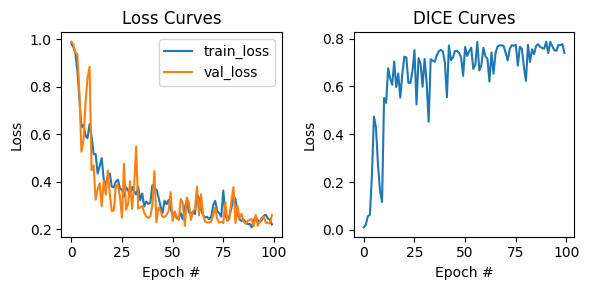

In [ ]:
# plot loss curves and DICe curves
fig_rows = 1
fig_cols = 2

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[6, 3])

axs.flat[0].set_title('Loss Curves')
axs.flat[0].plot(H["train_loss"], label="train_loss")
axs.flat[0].plot(H["val_loss"], label="val_loss")
axs.flat[0].set_xlabel("Epoch #")
axs.flat[0].set_ylabel("Loss")
axs.flat[0].legend()
axs.flat[1].set_title('DICE Curves')
axs.flat[1].plot(H["val_dice"], label="val_dice")
axs.flat[1].set_xlabel("Epoch #")
axs.flat[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

In [ ]:
# Load best model
model = torch.load('Models/Unet_3D')

In [ ]:
# Testing Set
test_ct = 0.0
testDice = 0.0
with torch.no_grad():
  for data in testLoader:
    x = data[0].unsqueeze(1).to(DEVICE)
    y = data[1].unsqueeze(1).to(DEVICE)

    y_hat = model(x)
    dice = 1-lossFunc(y, y_hat)
    testDice += dice
    test_ct += 1

avgDice = testDice/test_ct
print('Average DICE over Testing Set: {:.4f}'.format(avgDice.cpu().detach().numpy()))

Average DICE over Testing Set: 0.8413


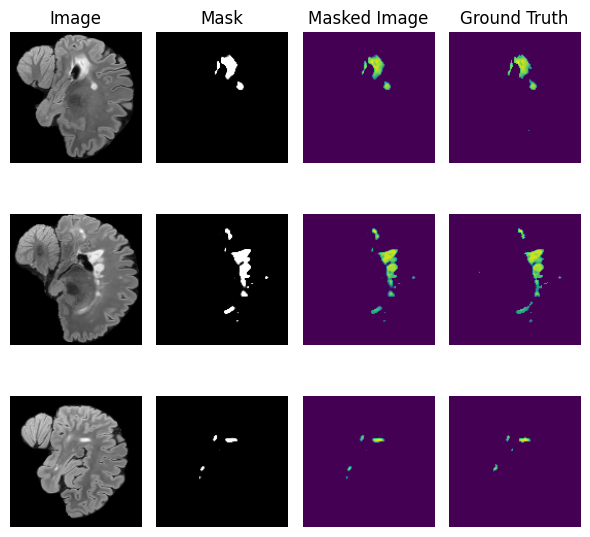

In [ ]:
# Example Segmentation from Validation Set
images, masks = next(iter(testLoader))   #training dataa
y_hat = model(images.unsqueeze(1).to(DEVICE))
im1 = images[0].detach().cpu().numpy()
im2 = images[0].detach().cpu().numpy()
im3 = images[0].detach().cpu().numpy()
mask1 = y_hat[0].detach().cpu().numpy().squeeze()
mask2 = y_hat[0].detach().cpu().numpy().squeeze()
mask3 = y_hat[0].detach().cpu().numpy().squeeze()
im_m1 = im1*mask1
im_m2 = im2*mask2
im_m3 = im3*mask3
gt_mask1 = masks[0].detach().cpu().numpy()
gt_mask2 = masks[0].detach().cpu().numpy()
gt_mask3 = masks[0].detach().cpu().numpy()
gt_m1 = im1*gt_mask1
gt_m2 = im2*gt_mask2
gt_m3 = im3*gt_mask3

fig_rows = 3
fig_cols = 4

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[6, 6])
sl = 90

axs.flat[0].set_title('Image')
axs.flat[0].imshow(im1[sl,:,:], cmap='gray')
axs.flat[0].axis('off')
axs.flat[1].set_title('Mask')
axs.flat[1].imshow(mask1[sl,:,:], cmap='gray')
axs.flat[1].axis('off')
axs.flat[2].set_title('Masked Image')
axs.flat[2].imshow(im_m1[sl,:,:])
axs.flat[2].axis('off')
axs.flat[3].set_title('Ground Truth')
axs.flat[3].imshow(gt_m1[sl,:,:])
axs.flat[3].axis('off')
axs.flat[4].imshow(im2[sl-10,:,:], cmap='gray')
axs.flat[4].axis('off')
axs.flat[5].imshow(mask2[sl-10,:,:], cmap='gray')
axs.flat[5].axis('off')
axs.flat[6].imshow(im_m2[sl-10,:,:])
axs.flat[6].axis('off')
axs.flat[7].imshow(gt_m2[sl-10,:,:])
axs.flat[7].axis('off')
axs.flat[8].imshow(im3[sl+10,:,:], cmap='gray')
axs.flat[8].axis('off')
axs.flat[9].imshow(mask3[sl+10,:,:], cmap='gray')
axs.flat[9].axis('off')
axs.flat[10].imshow(im_m3[sl+10,:,:])
axs.flat[10].axis('off')
axs.flat[11].imshow(gt_m3[sl+10,:,:])
axs.flat[11].axis('off')

plt.tight_layout()
plt.show()

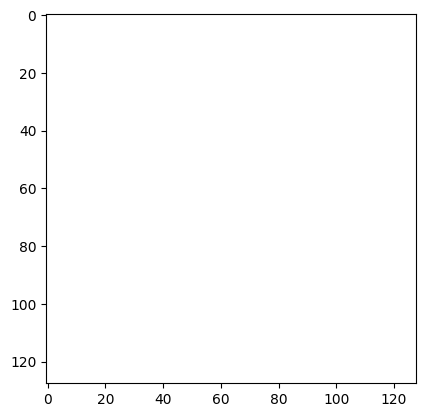

In [ ]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)

mask1[mask1<0.5] = 0.0
mask1[mask1>=0.5] = 1.0

for i in range(im1.shape[0]):
  plt.imshow(im1[i,:,:], cmap='gray')
  mask_ = np.ma.masked_where(mask1[i,:,:] == 0, mask1[i, :, :])
  plt.imshow(mask_, alpha=0.5)
  camera.snap()

visualization = camera.animate()

In [ ]:
HTML(visualization.to_html5_video())

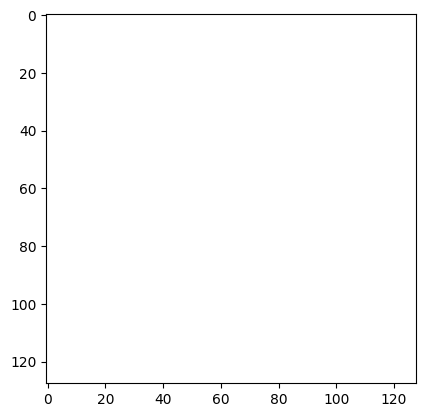

In [ ]:
fig = plt.figure()
camera = Camera(fig)

for i in range(im1.shape[0]):
  plt.imshow(im1[i,:,:], cmap='gray')
  mask_ = np.ma.masked_where(gt_mask1[i,:,:] == 0, gt_mask1[i, :, :])
  plt.imshow(mask_, alpha=0.5)
  camera.snap()

visualization = camera.animate()

In [ ]:
HTML(visualization.to_html5_video())

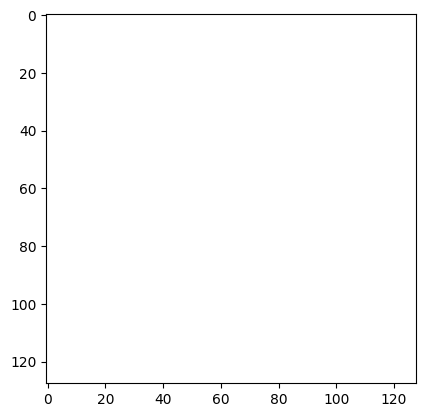

In [ ]:
fig = plt.figure()
camera = Camera(fig)

mask_diff = mask1 + gt_mask1

for i in range(mask_diff.shape[0]):
  plt.imshow(mask_diff[i,:,:])
  camera.snap()

visualization = camera.animate()

In [ ]:
HTML(visualization.to_html5_video())